## Многообразие сервисов в кварталах города

В рамках данной работы были выбраны сервисы *"Дошкольные образовательные учреждения"*. 
В Миассе насчитывается 61 детский сад, и они разнесены по всей территории города. 
Данный вид сервиса является *конкурентным (rival)*, так как имеет фиксированную вместимость. 


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_31166/1822539265.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to m

In [2]:
# Загрузка данных
quarters = gpd.read_file("/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/Clusters/blocks.geojson")
services = gpd.read_file("/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/kindergarten.geojson")


При работе с кварталами было обнаружено, что есть мультиполигональные кварталы, которые мы разделили на отдельные независимые кварталы

/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_31166/646153224.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  quarters_exp = quarters.explode()


<AxesSubplot: >

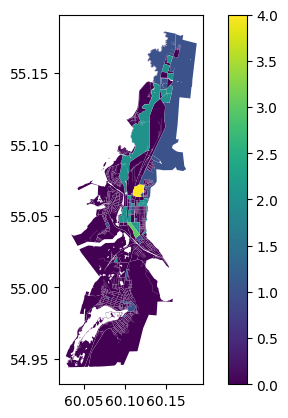

In [3]:
# Разделение мультиполигонов на отдельные полигоны и обновление id
quarters_exp = quarters.explode()
if 'id' in quarters_exp.columns:
    quarters_exp = quarters_exp.rename(columns={'id': 'old_id'})

# Создание нового столбца id
quarters_exp['id'] = range(1, len(quarters_exp) + 1)


quarters_exp['service_count'] = 0

# Итерация по каждому кварталу
for index, quarter in quarters_exp.iterrows():
    services_within_quarter = services[services.geometry.within(quarter.geometry)]
    service_count = len(services_within_quarter)
    quarters_exp.at[index, 'service_count'] = service_count

quarters_exp.plot(column='service_count', cmap='viridis', legend=True)

## Визуализация результата

In [4]:
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster


Чтобы неперегружать картинку было принято решение убрать кварталы, в которых нет детских садов

In [5]:
# Фильтрация кварталов, в которых есть сервисы
quarters_with_services = quarters_exp[quarters_exp['service_count'] > 0]

m = folium.Map(location=[quarters_exp.geometry.centroid.y.mean(), quarters_exp.geometry.centroid.x.mean()], zoom_start=13, tiles='cartodb positron')

folium.Choropleth(
    geo_data=quarters_with_services,
    name='Choropleth',
    data=quarters_with_services,
    columns=['id', 'service_count'],
    key_on='feature.properties.id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Service Count'
).add_to(m)

# Добавление маркеров сервисов
marker_cluster = MarkerCluster().add_to(m)

for index, service in services.iterrows():
    if service.geometry.type == 'Point':
        location = [service.geometry.y, service.geometry.x]
    elif service.geometry.type == 'MultiPoint':
        location = [service.geometry.centroid.y, service.geometry.centroid.x]

    folium.Marker(
        location=location,
        popup=f'Service name: {service["Наименование"]}',
    ).add_to(marker_cluster)

folium.GeoJson(
    quarters_exp,
    name='Quarters',
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 0,
        'dashArray': '5, 5'
    },
    highlight_function=lambda x: {'weight': 3, 'fillColor': 'gray', 'color': 'gray'},
    tooltip=folium.GeoJsonTooltip(fields=['id', 'service_count'], aliases=['Quarter ID', 'Service Count'], labels=True, sticky=False),
).add_to(m)



# Сохранение карты в файл
m.save('interactive_map.html')

/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_31166/3452376670.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[quarters_exp.geometry.centroid.y.mean(), quarters_exp.geometry.centroid.x.mean()], zoom_start=13, tiles='cartodb positron')
/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_31166/3452376670.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[quarters_exp.geometry.centroid.y.mean(), quarters_exp.geometry.centroid.x.mean()], zoom_start=13, tiles='cartodb positron')
/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_31166/3452376670.py:22: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be remove

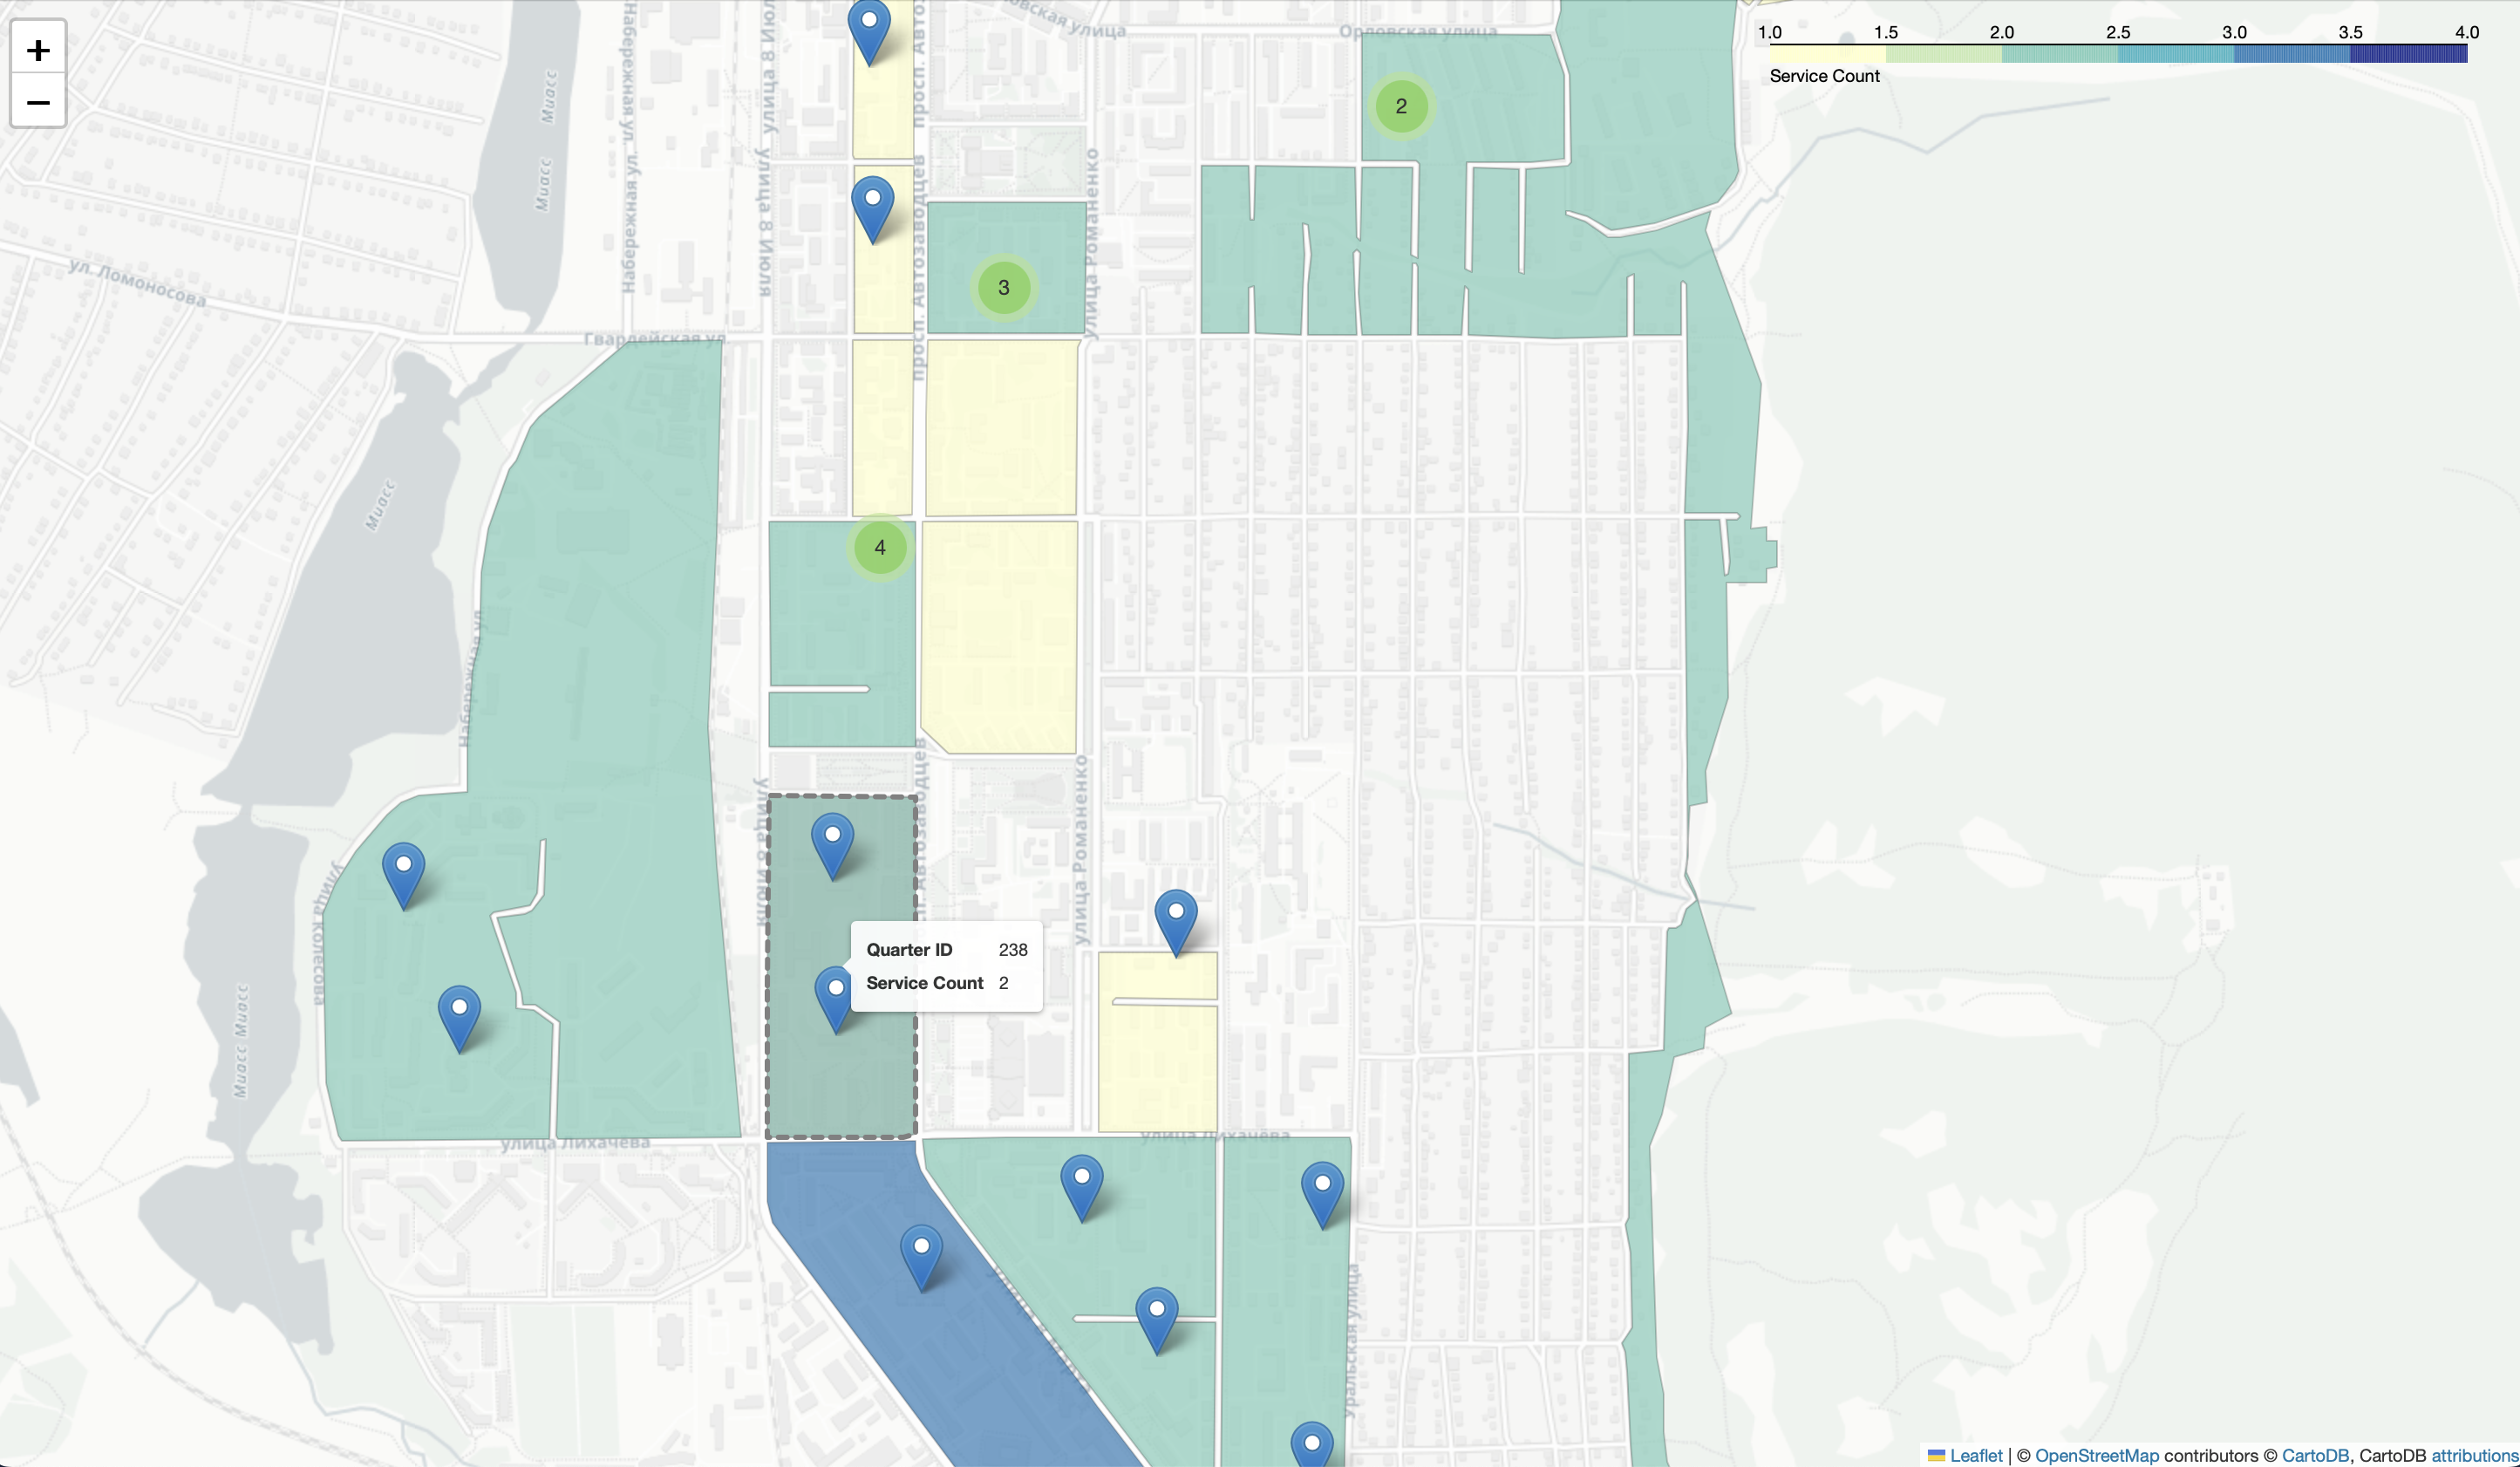

In [6]:
from IPython.display import Image, display
display(Image(filename='/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/Снимок экрана 2023-12-04 в 14.21.33.png', embed=True))

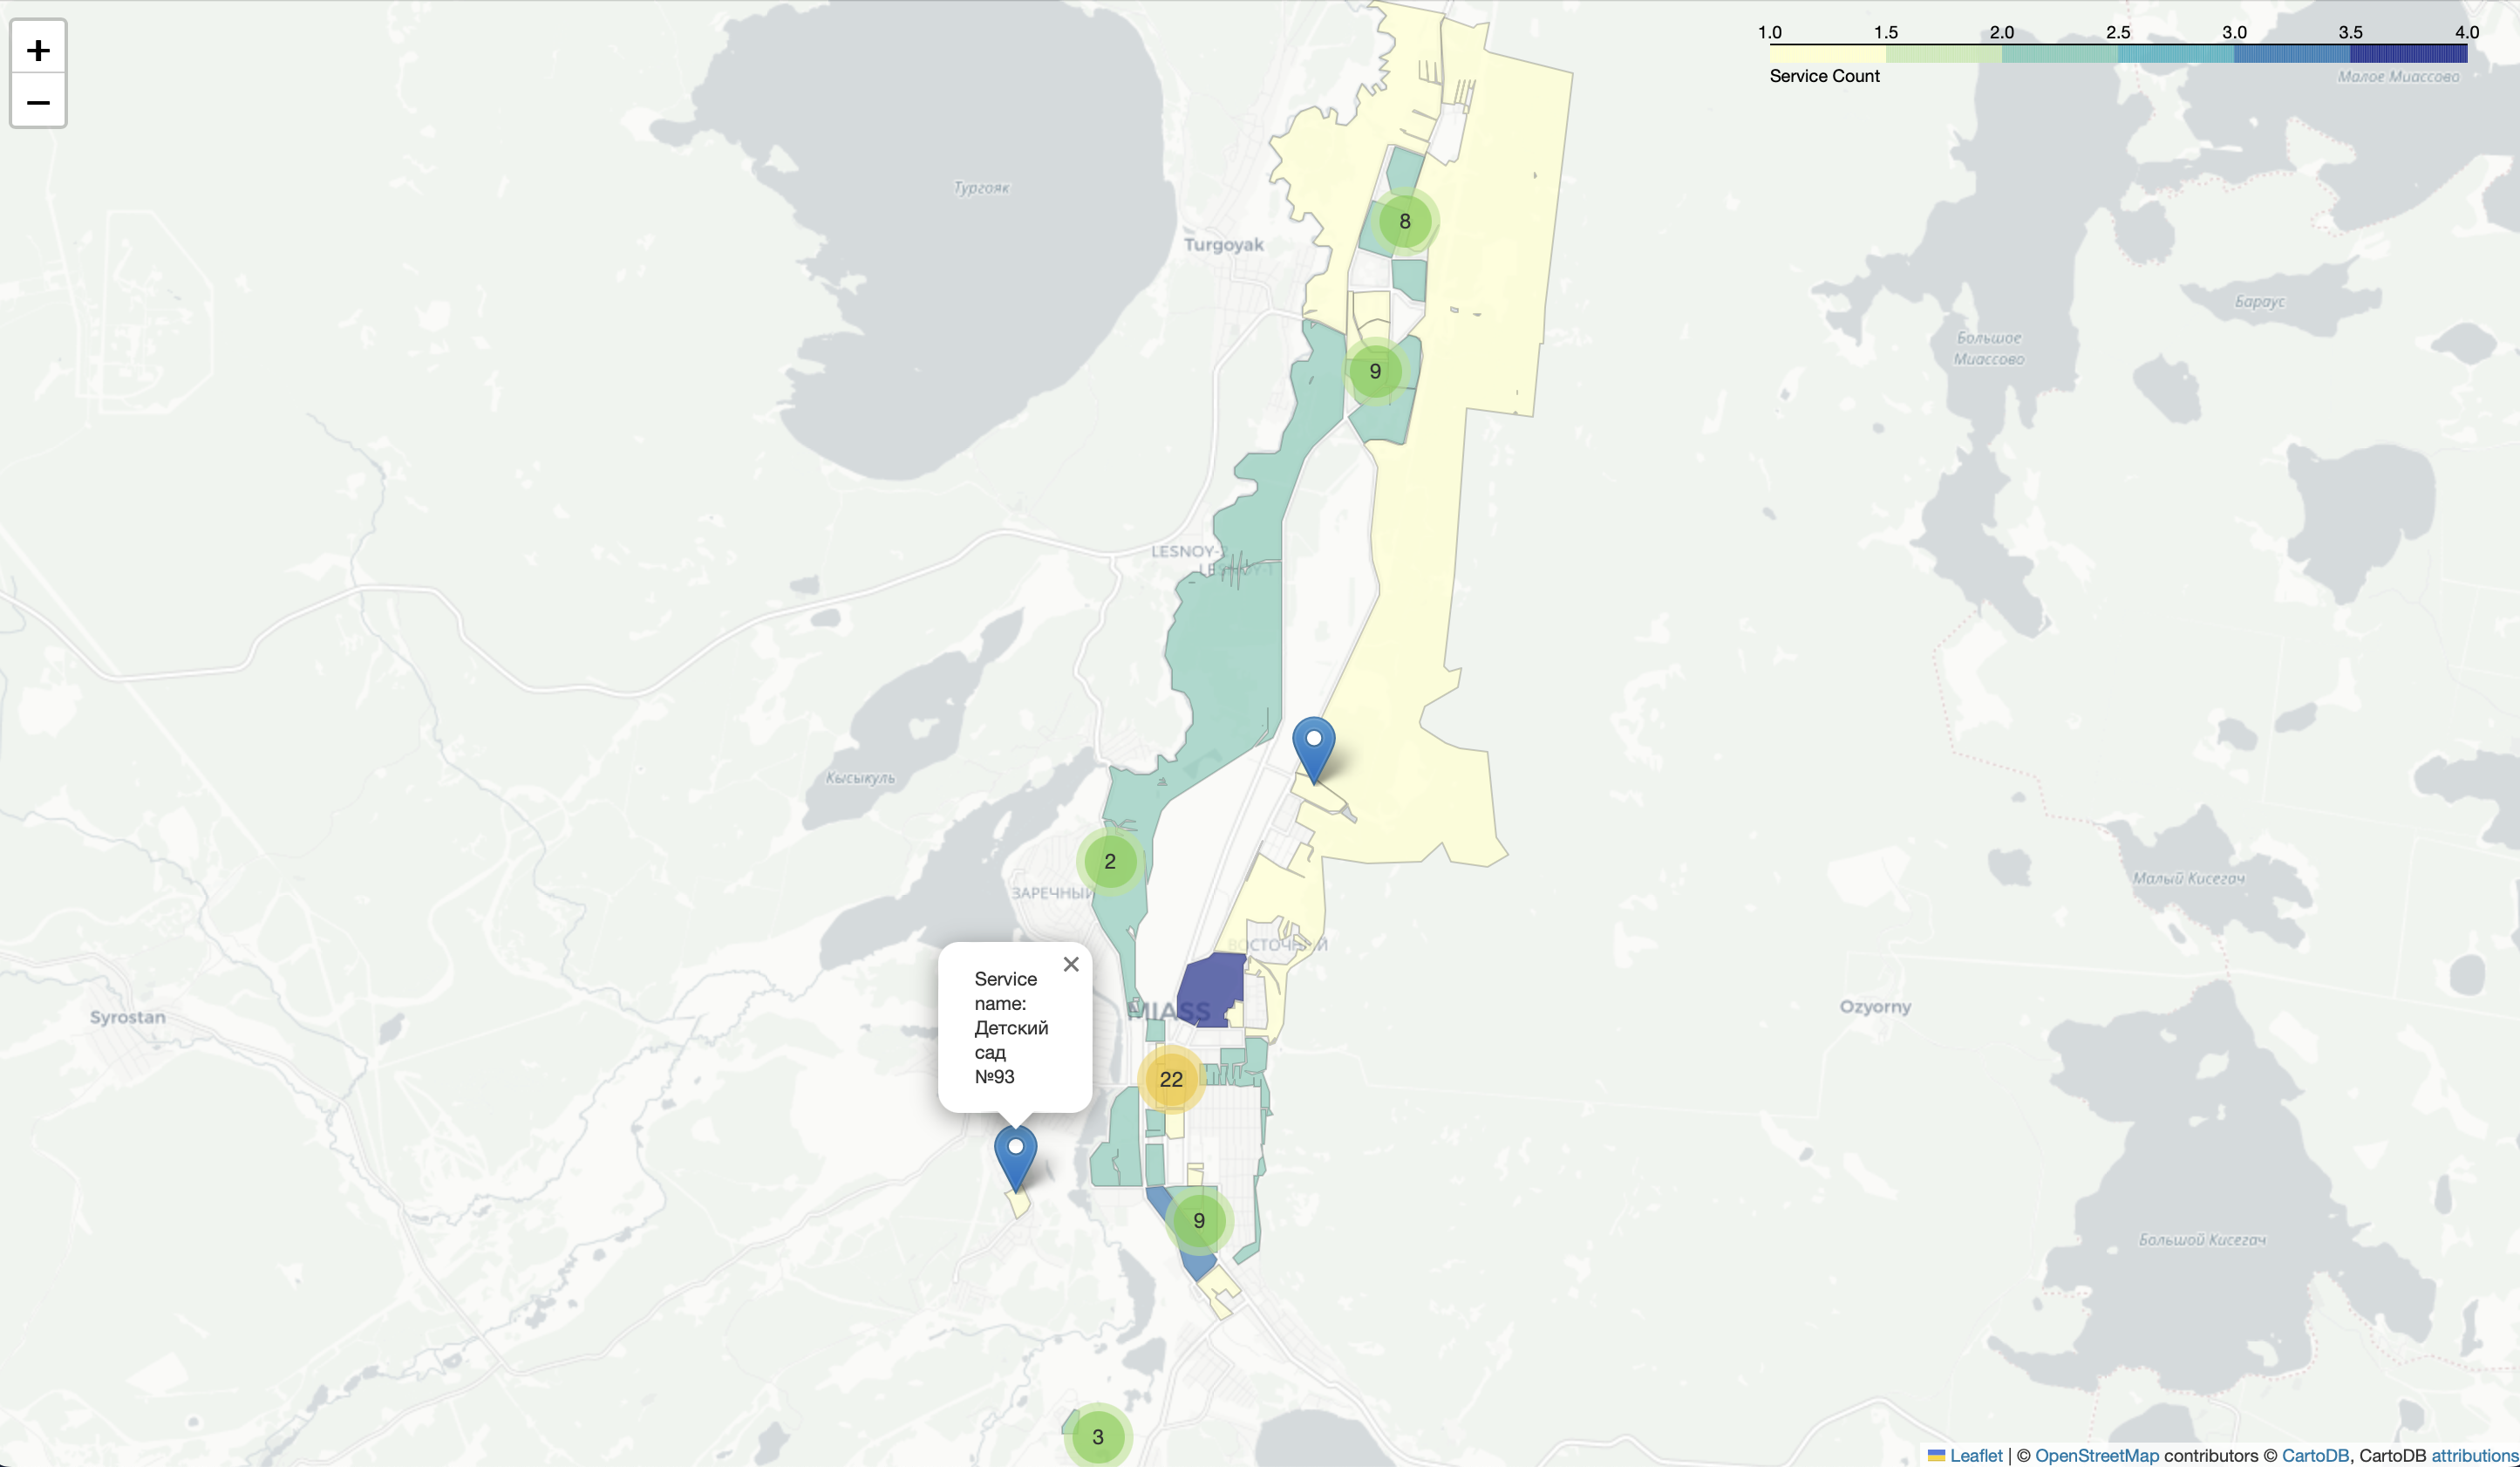

In [7]:
display(Image(filename='/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/Снимок экрана 2023-12-04 в 14.31.02.png', embed=True))

На основании получившегося файла с информацией о количестве сервисов в каждом квартале, мы можем посмотреть общую вместимость сервисов, и сколько человек проживает в квартале,которым требуется данный вид сервиса. Таким образом сопоставить два значения. 

Не менее значимым может быть наложение скопления людей, которым необходи сервис и где детские сады находятся. Таким образом посмотреть где есть нехватка садов территориально, или же людям приходится затрачивать большее время, чтобы добраться.